# Librerías a utilizar

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Dropout , Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import imageio
import predict
import cv2

# Ubicación del dataset

In [2]:
base_dir = 'Rio-coca-dataset'
train_test_split = 0.75
no_of_files_in_each_class = 10

# Conteo de categorías

In [3]:
#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

23 categories found in the dataset


In [4]:
#Declare training array
cat_list = []
x = []
y = []
y_label = 0

# Preparación de la dataset

In [5]:
#Using just 10 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((600, 300))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)  

X, Y shape (230, 300, 600, 3) (230,) (23, 10)


# Preparación del data entrenamiento y data de validación en proporción 75 / 25 

In [6]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of validation data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

17 classes for training and 6  classes for testing
X&Y shape of training data : (170, 300, 600, 3) and (170,) (17, 10)
X&Y shape of validation data : (60, 300, 600, 3) and (60,) (6, 10)


In [7]:
#x_train

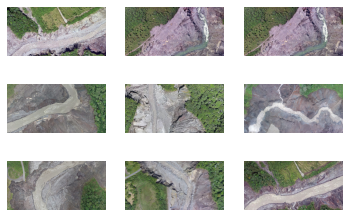

In [8]:
#Plotting Images
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)])
plt.show()

# Prepara data de entrenamiento en lotes

In [9]:
def get_batch(batch_size=64, call_type='train'):
    
    temp_x = None
    temp_cat_list = None
    start=None
    end=None
    batch_x=[]
    
    if call_type == 'train':
        temp_x = x_train
        temp_cat_list = cat_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_cat_list = cat_test
        start = train_size+1
        end = len(folder_list)-1
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 300, 600, 3)))
    batch_x.append(np.zeros((batch_size, 300, 600, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

# Modelo Convolucional

In [10]:
input_shape=(300, 600, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
input=[left_input, right_input]

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

conv = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, padding="same", activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(64, 3, padding="same", activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, 3,  padding="same", activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(5,5),
    keras.layers.Dropout(0.4),
 
])


encoded_l = conv(left_input)
encoded_r = conv(right_input)

# LAYER TO COMPUTE THE ABSOLUTE DIFFERENCE BETWEEN THE ENCODINGS
L1_layer = Lambda(lambda tensor: abs(tensor[0] - tensor[1]), name= "DISTANCIA")
L1_distance = L1_layer([encoded_l, encoded_r])

Norm_layer=keras.layers.BatchNormalization()(L1_distance)


In [11]:
conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 600, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 300, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 300, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 150, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 150, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 30, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 30, 128)       0

# Deconvolución

In [12]:
Deco= keras.models.Sequential([
    keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), 
                        strides=(1,1), padding= "same",
                        activation='relu', 
                        name= "DeConv_1"),
    keras.layers.UpSampling2D((5),name="UpSamp_1"),
    
    keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3),
                        strides=(1,1), padding= "same",
                        activation='relu',
                        name="DeConv_2"),
    keras.layers.UpSampling2D((2),name="UpSamp_2"),
    
    keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), 
                        strides=(1,1), padding= "same",
                        activation='relu',
                        name="DeConv_3"),
    keras.layers.UpSampling2D((2),name="UpSamp_3"),
    
    
    keras.layers.Conv2D(filters=3, kernel_size=(3,3), 
                        strides=(1,1), padding= "same",
                        activation='sigmoid', 
                        name="vector_result"),
], name= "DECODER")

vector_result= Deco(L1_distance)  

Modelo = Model(inputs=[left_input,right_input], outputs=[vector_result],name = 'DECODER_F')

siamese_net = Model(input, Modelo)

optimizer= Adam(learning_rate=0.0006)

siamese_net.compile(loss='contrastive_loss', optimizer=optimizer,metrics=['accuracy'])


In [13]:
Deco.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeConv_1 (Conv2DTranspose)   (None, 15, 30, 128)       147584    
_________________________________________________________________
UpSamp_1 (UpSampling2D)      (None, 75, 150, 128)      0         
_________________________________________________________________
DeConv_2 (Conv2DTranspose)   (None, 75, 150, 64)       73792     
_________________________________________________________________
UpSamp_2 (UpSampling2D)      (None, 150, 300, 64)      0         
_________________________________________________________________
DeConv_3 (Conv2DTranspose)   (None, 150, 300, 32)      18464     
_________________________________________________________________
UpSamp_3 (UpSampling2D)      (None, 300, 600, 32)      0         
_________________________________________________________________
vector_result (Conv2D)       (None, 300, 600, 3)       867 

In [14]:
vector_result.shape

TensorShape([None, 300, 600, 3])

# Función para determinar el porcentaje de acierto en la predicción

In [15]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 300, 600, 3)))
        temp.append(np.zeros((n_way, 300, 600, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
   
    accuracy = (n_correct*100)/n_val
    return accuracy

# Entrenamiento

In [16]:
epochs = 10
n_way = 5
n_val = 7
batch_size = 64

epoch_list=[]
loss_list=[]
accuracy_list=[]
siamese_net, model = predict.sm()
for epoch in range(1,epochs+1):
    batch_x, batch_y = get_batch(batch_size, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append(loss)
    accuracy = nway_one_shot(model , n_way, n_val)
    accuracy = nway_one_shot(model, n_way, n_val)
    accuracy_list.append(accuracy)
    epoch_list.append(epoch)
    print('Epoch:', epoch, 'Accuracy , Loss:' , loss)

Epoch: 1 Accuracy , Loss: [0.7218329906463623, 0.5]
Epoch: 2 Accuracy , Loss: [0.7266779541969299, 0.5]
Epoch: 3 Accuracy , Loss: [0.7230313420295715, 0.5]
Epoch: 4 Accuracy , Loss: [0.7237331867218018, 0.5]
Epoch: 5 Accuracy , Loss: [0.723284900188446, 0.5]
Epoch: 6 Accuracy , Loss: [0.7235317826271057, 0.5]
Epoch: 7 Accuracy , Loss: [0.7234148383140564, 0.5]
Epoch: 8 Accuracy , Loss: [0.7231943011283875, 0.5]
Epoch: 9 Accuracy , Loss: [0.7232608795166016, 0.5]
Epoch: 10 Accuracy , Loss: [0.7231450080871582, 0.5]


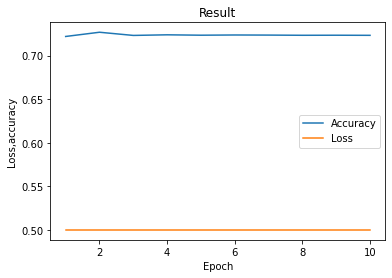

In [17]:
plt.plot(epoch_list,loss_list,label=["Accuracy","Loss"])
plt.ylabel('Loss,accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Result')
plt.show()

# Test

In [18]:
imagepath1 = 'test/Z12-1_RC11.jpg'
imagepath2 = 'test/Z12-1_RC17.jpg'
image1 = imageio.imread(imagepath1) 
image2 = imageio.imread(imagepath2)

In [19]:
result = predict.Modelo(image1,image2)

In [21]:
matriz_result=predict.nparray(result,300,600)
matriz_result

Array([[[0.04313725, 0.09019608, 1.        ],
        [0.13333333, 0.17647059, 0.07843137],
        [0.03137255, 0.03921569, 0.95686275],
        ...,
        [0.43529412, 0.50980392, 0.40392157],
        [0.76862745, 0.83921569, 0.72156863],
        [0.73333333, 0.80392157, 0.67843137]],

       [[0.0745098 , 0.1372549 , 0.02352941],
        [0.09803922, 0.15294118, 0.05098039],
        [0.09803922, 0.13333333, 0.02745098],
        ...,
        [0.55294118, 0.62745098, 0.50980392],
        [0.56862745, 0.63921569, 0.51372549],
        [0.78039216, 0.85490196, 0.70980392]],

       [[0.96470588, 0.08235294, 0.92941176],
        [0.02352941, 0.1254902 , 0.98431373],
        [0.9372549 , 0.        , 0.88627451],
        ...,
        [0.62352941, 0.70196078, 0.57254902],
        [0.58039216, 0.65882353, 0.50980392],
        [0.88235294, 0.95686275, 0.8       ]],

       ...,

       [[0.03529412, 0.95686275, 0.09019608],
        [0.17254902, 0.07843137, 0.21960784],
        [0.10588235, 0

# Mapa de cambios

In [22]:
matriz__result[matriz__result == distance] = 255
matriz__result[matriz__result != 255] = 0
change_map = matriz__result.astype(np.uint8)

In [23]:
change_map

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

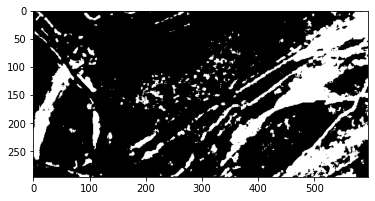

In [24]:
imgplot = plt.imshow(matriz__result)
imgplot.set_cmap('gray')

# Tripleta de imágenes

Text(0.5, 1.0, 'Cambios')

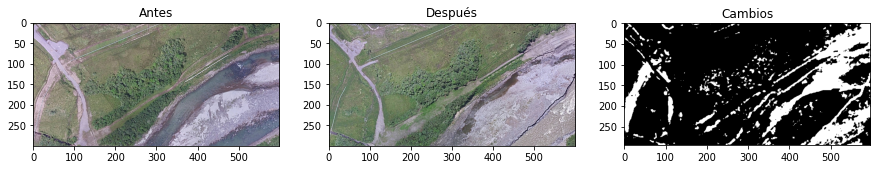

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 20))

ax = fig.add_subplot(2, 3, 1)
imgplot = plt.imshow(image1)
ax.set_title('Antes')

ax = fig.add_subplot(2, 3, 2)
imgplot = plt.imshow(image2)
ax.set_title('Después')

ax = fig.add_subplot(2, 3, 3)
imgplot = plt.imshow(change_map)
imgplot.set_cmap('gray')
ax.set_title('Cambios')